In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
import myutils
import importlib
import yolo_utils

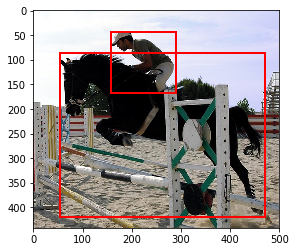

In [2]:
root_path = r'D:\Documents\Data_Files\Datasets\Pascal\VOC2012'
dataset = myutils.Dataset(root_path)
mx_dataset = dataset.transform(yolo_utils.transform_fn)
img, label = dataset[0]
myutils.data_visualize(img, label[:, 1:])
plt.show()

In [3]:
batch_size = 10
dataloader = mx.gluon.data.DataLoader(mx_dataset, batch_size=batch_size, shuffle=True, 
                                      last_batch='rollover', batchify_fn=yolo_utils.batchify_fn)

In [4]:
ctx = mx.cpu()
img_size = (300, 300)  # height, width
yolo_v1 = yolo_utils.YOLO_v1(ctx=ctx)
yolo_v1.hybridize()

yolo_v1.load_parameters('d:/Documents/Data_Files/Parameters/params_loss_less_than_7300')

output = yolo_v1(mx.nd.random.normal(shape=(2, 3, img_size[0], img_size[1]), ctx=ctx))
print(output.shape)

(2, 7, 7, 30)


In [ ]:
trainer = mx.gluon.Trainer(yolo_v1.collect_params(), 'sgd')
trainer.set_learning_rate(0.0001)

In [ ]:
for epoch in range(10):
    epoch_loss = 0
    for mx_imgs, mx_labels in dataloader:
        with mx.autograd.record():
            tensor_preds = yolo_v1(mx_imgs.as_in_context(ctx))
            tensor_targs = yolo_utils.generate_target_batch(img_size, mx_labels.as_in_context(ctx), tensor_preds)
            loss = yolo_utils.calc_batch_loss(tensor_preds, tensor_targs)
        batch_loss = loss.abs().mean()
        epoch_loss += batch_loss
    loss.backward()
    trainer.step(batch_size)
    print('epoch', epoch, 'loss:', epoch_loss)

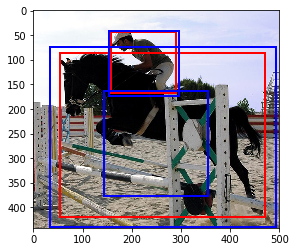

In [5]:
img, label = dataset[0]
mx_img, mx_label = myutils.prepare_datum_for_net(img, label, size=(300, 300))
tensor_preds = yolo_v1(mx_img.as_in_context(ctx))
tensor_pred = tensor_preds[0]
yolo_utils.visualize_pred(img, label, tensor_pred.asnumpy())
plt.show()

In [116]:
scores_class_boxes = yolo_utils.get_pred_scores_class_and_boxes(img.shape[:2], tensor_pred)

In [117]:
scores_class_boxes_nms = mx.nd.contrib.box_nms(mx.nd.array(scores_class_boxes), 
                                               overlap_thresh=0.5, valid_thresh=0.02, score_index=0, id_index=1)
scores_class_boxes_nms = scores_class_boxes_nms.asnumpy()
scores_class_boxes_nms = scores_class_boxes_nms[scores_class_boxes_nms[:, 0] != -1]

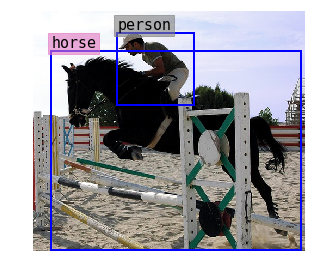

In [150]:
importlib.reload(myutils)
cls_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                       'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
                       'train', 'tvmonitor']
fig = myutils.visualize_pred(img, label, scores_class_boxes_nms, class_names_list=cls_names, show_label=False)
fig.set_figwidth(5)
fig.set_figheight(fig.get_figwidth() * img.shape[0] / img.shape[1])
fig

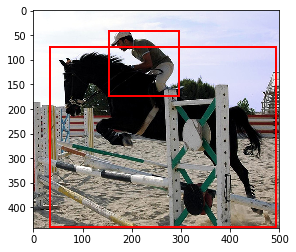

In [125]:
myutils.data_visualize(img, scores_class_boxes_nms[:, 2:])
plt.show()